In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, methylation_motifs
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

In [4]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import shap
from pymemesuite.common import MotifFile
import Bio.SeqIO
from pymemesuite.common import Sequence
from pymemesuite.fimo import FIMO


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# TCGA data

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [7]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}

# for each cv iteration
for cv_num in [3]:#, 0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn
    )
    # add to dictionary
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
        directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_dict[cv_num] = somage_tcga

The least populated class in y has only 2 members, which is less than n_splits=5.


Creating soMage object


# ICGC data

In [54]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [72]:
mut_feat_icgc_dict = {}
somage_icgc_dict = {}

# for each cv iteration
for cv_num in [1]:#, 0]:
    # create a mutation features object
    mut_feat_icgc = mutation_features.mutationFeatures(
        all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = "./", 
        consortium = 'ICGC', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = icgc_matrix_qtl_dir,
        covariate_fn = icgc_covariate_fn
    )
    # add to dictionary
    mut_feat_icgc_dict[cv_num] = mut_feat_icgc
    # and create a somage object from the seperate somage outputs
    somage_icgc = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output",
        directory_glob = f"ICGC__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_icgc,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = icgc_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output"
        )
    # read in pre-comp prediction performance by dset
    somage_icgc.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_icgc_dict[cv_num] = somage_icgc

Creating soMage object


The least populated class in y has only 1 members, which is less than n_splits=5.


In [9]:
icgc_methyl_age_df_t['dataset'].value_counts()

PRAD    241
PACA    161
OV       92
PBCA     72
CLLE     47
PAEN     22
UTCA     16
Name: dataset, dtype: int64

# Re-format illumina cpg locs

In [55]:
illumina_cpg_locs_df2 = pd.read_csv("/cellar/users/zkoch/methylation_and_mutation/dependency_files/illumina_cpg_450k_locations_one_hot_encoded.csv", low_memory=False)

In [56]:
illumina_cpg_locs_df2

,#id,chr,start,Strand,TSS1500,Body,TSS200,1stExon,5'UTR,3'UTR,...,Enhancer,Gene_Associated,Gene_Associated_Cell_type_specific,NonGene_Associated,NonGene_Associated_Cell_type_specific,Promoter_Associated,Promoter_Associated_Cell_type_specific,Unclassified,Unclassified_Cell_type_specific,DHS
0,cg00035864,Y,8553009,F,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,cg00050873,Y,9363356,R,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,cg00061679,Y,25314171,R,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,cg00063477,Y,22741795,F,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,cg00121626,Y,21664296,R,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485457,cg27657537,22,20863762,F,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
485458,cg27660038,22,20378532,F,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
485459,cg27662284,22,20342520,F,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
485460,cg27662611,22,38598981,F,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# TCGA Feat importance by category

In [89]:
# for each of the best predicted CpGs 
cv_num = 3
top_cpgs = 100
dataset = 'UCEC'

top_cpgs_list = somage_tcga_dict[cv_num].performance_by_dataset_df.query('dataset == @dataset').sort_values(
    by = 'AvP_methyl_spearman', ascending = False
    ).head(top_cpgs)['cpg']


all_feat_imp_dfs = []
all_feat_imp_by_cat_dfs = []
for cpg in top_cpgs_list:
    # get the model and feature names
    model, feat_names, train_mat, test_mat = (
        somage_tcga_dict[cv_num]
        .get_model_feat_names_train_test(cpg, dataset = dataset)
        )
    feat_imp_df, feat_imp_by_cat_df = somage_tcga_dict[cv_num].get_one_cpg_feat_score_by_cat(
        model, feat_names, train_mat, test_mat, 
        importance_calculator = 'shap', importance_type = "gain"
        )
    feat_imp_df['cpg'] = cpg
    feat_imp_by_cat_df['cpg'] = cpg
    all_feat_imp_dfs.append(feat_imp_df)
    all_feat_imp_by_cat_dfs.append(feat_imp_by_cat_df)
    
all_feat_imp_df = pd.concat(all_feat_imp_dfs).drop_duplicates()
all_feat_imp_by_cat_df = pd.concat(all_feat_imp_by_cat_dfs).drop_duplicates()

In [92]:
all_feat_imp_df.sort_values(by = 'importance', ascending = False)

,feat_name,importance,category,cpg
3,17:1083121,1.869067,Nearby locus,cg04532952
3,17:1375289,1.864990,Nearby locus,cg06613765
768,3:134339688,1.583008,Nearby locus,cg01788444
1158,16:56703818,1.448555,Nearby locus,cg04397593
428,17:32907872,1.164787,Nearby locus,cg09581049
...,...,...,...,...
1300,19:18546693,0.000000,Nearby locus,cg02446106
1299,19:18546673,0.000000,Nearby locus,cg02446106
1297,19:18546646,0.000000,Nearby locus,cg02446106
1296,19:18546633,0.000000,Nearby locus,cg02446106


<Axes: xlabel='category', ylabel='prop_nonzero'>

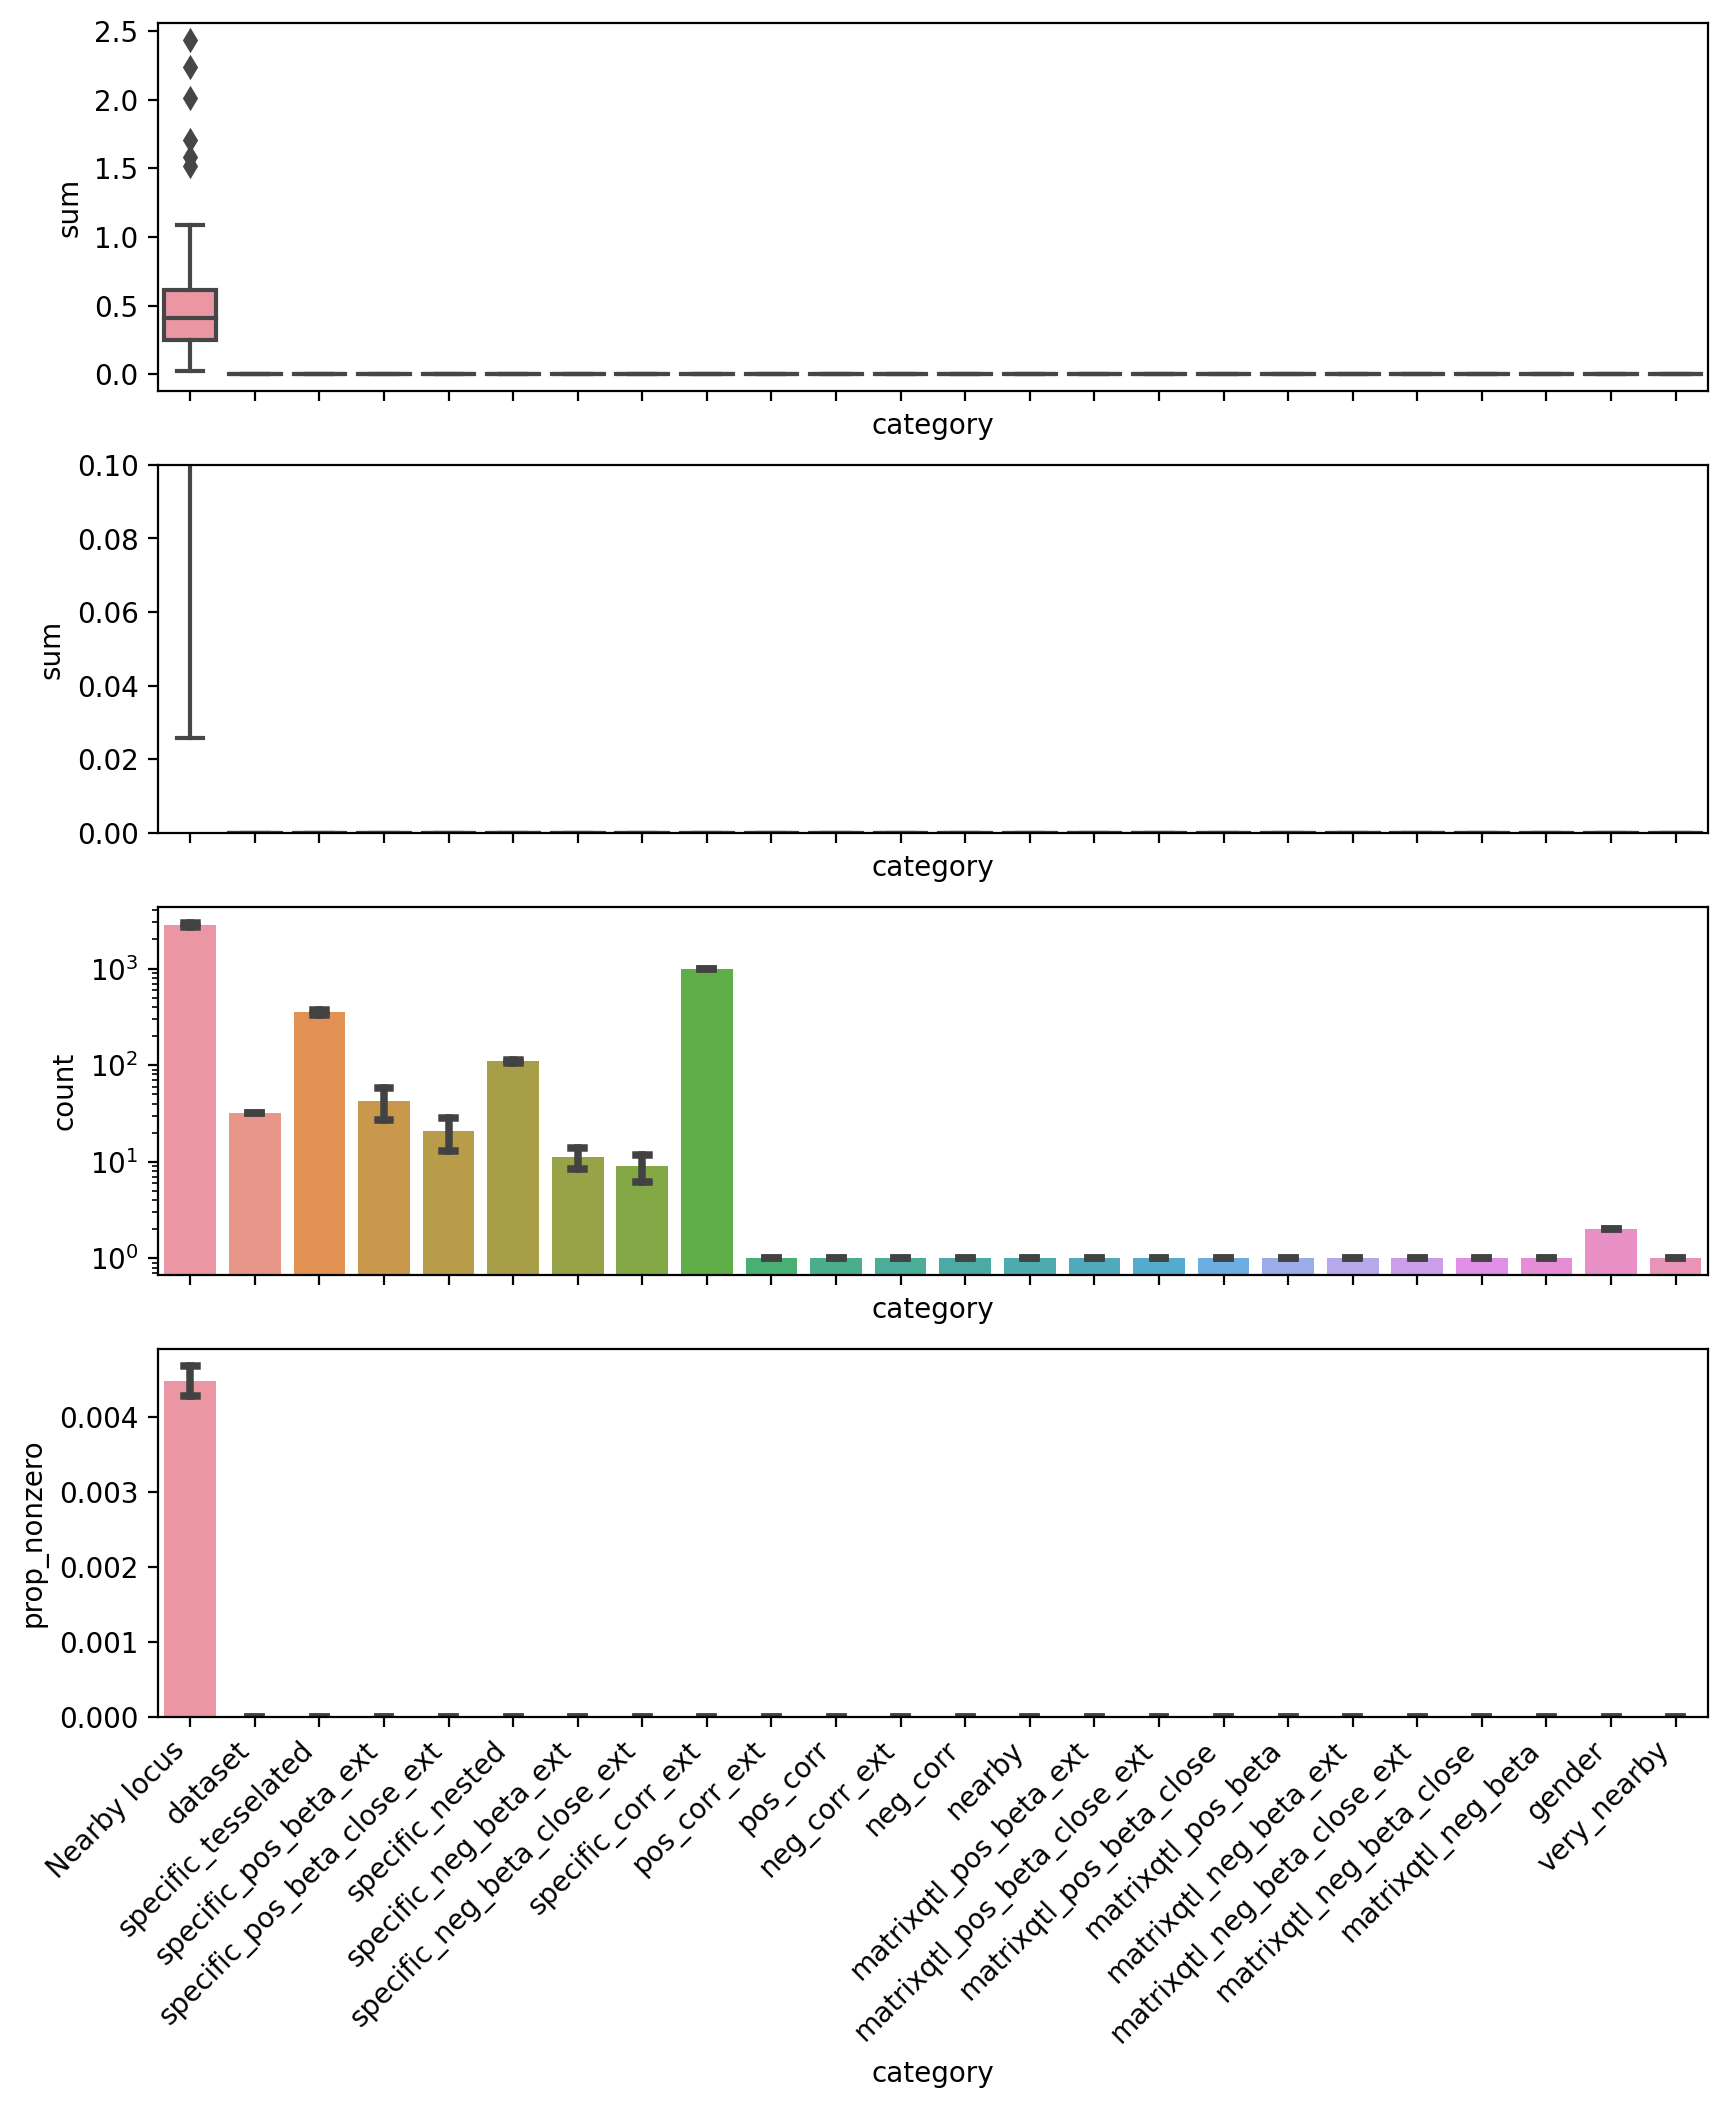

In [90]:
# w only dataset samples
metric = 'sum'

fig, axes = plt.subplots(4,1, figsize = (10,11), sharex = True)
order = (
    all_feat_imp_by_cat_df
    .groupby("category")[metric]
    .mean()
    .sort_values(ascending = False).index    )
sns.boxplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = metric,
    showfliers = True, ax = axes[0],
    order = order
    )

sns.boxplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = metric,
    showfliers = True, ax = axes[1],
    order = order
    )
axes[1].set_ylim(0, 0.1)
# log scale y axis
#axes[0].set_yscale('log')
# angle x labels
_ = plt.xticks(rotation=45, ha='right')

sns.barplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = "count",
    ax = axes[2],
    order = order, errorbar = 'se',
    capsize=0.2
    
    )
# set y axis to log scale
axes[2].set_yscale('log')

sns.barplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = "prop_nonzero",
    ax = axes[3],
    order = order, errorbar = 'se',
    capsize=0.2
    )

<Axes: xlabel='category', ylabel='prop_nonzero'>

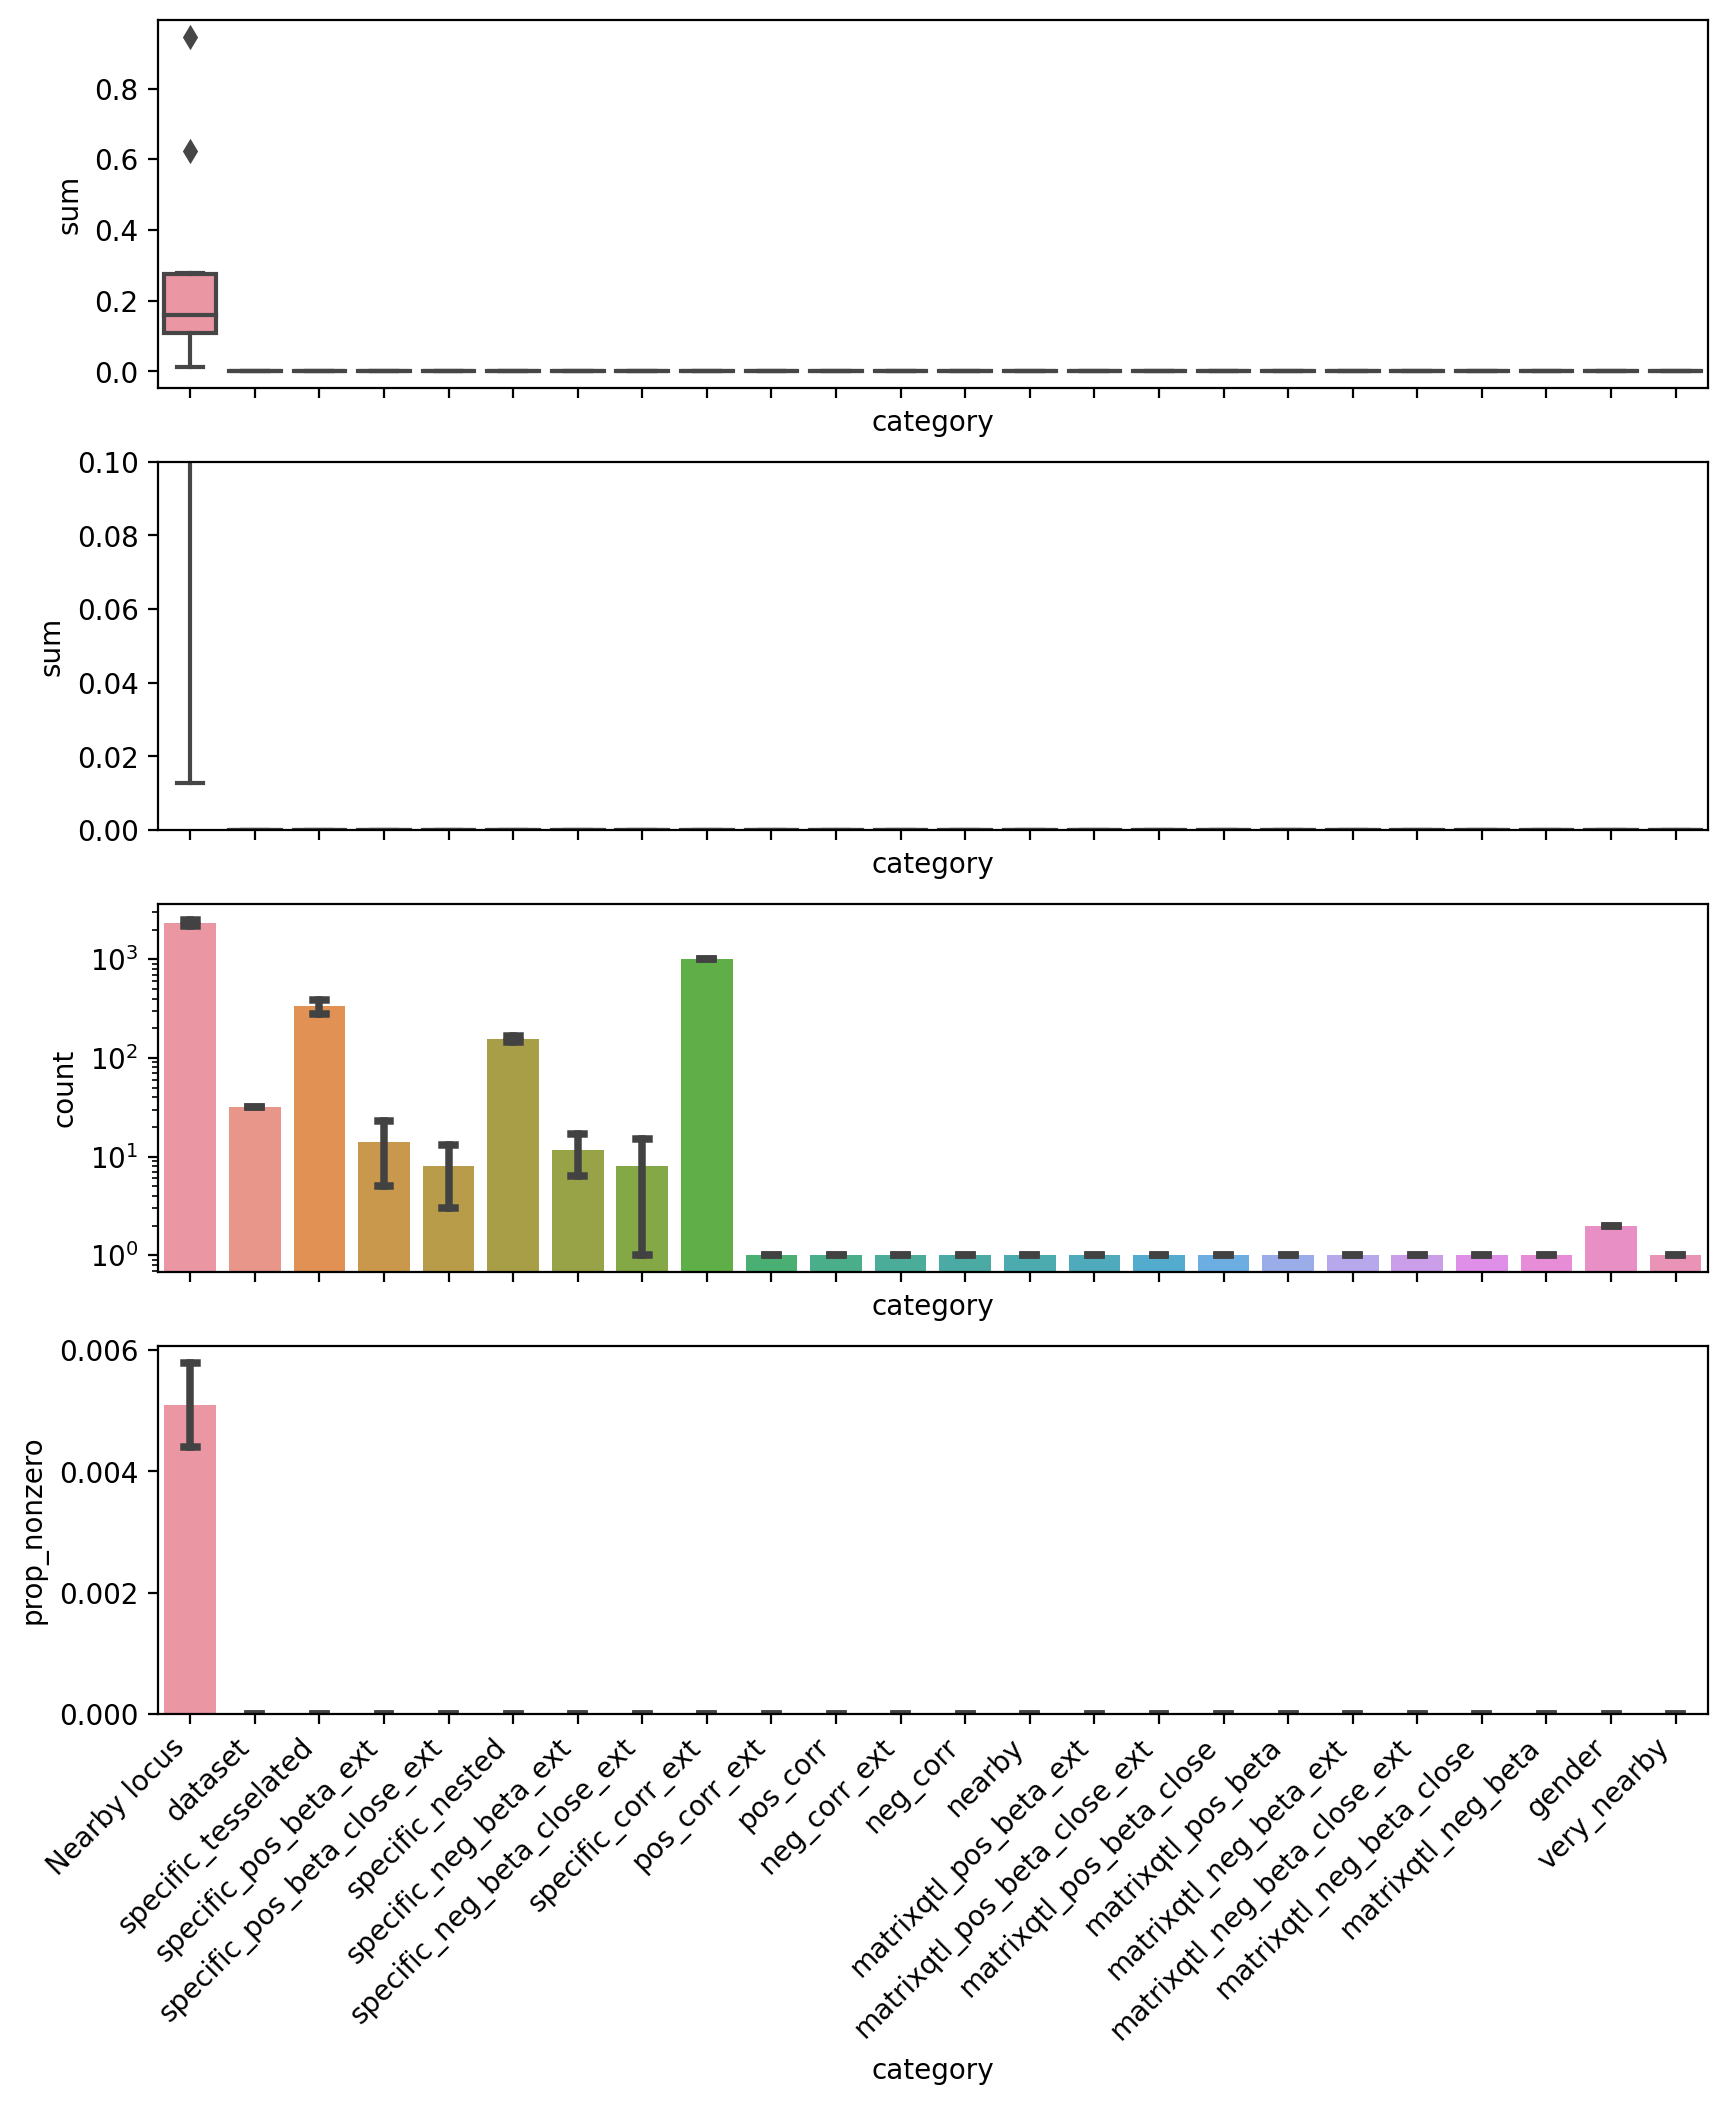

In [69]:
# shap
metric = 'sum'

fig, axes = plt.subplots(4,1, figsize = (10,11), sharex = True)
order = (
    all_feat_imp_by_cat_df
    .groupby("category")[metric]
    .mean()
    .sort_values(ascending = False).index    )
sns.boxplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = metric,
    showfliers = True, ax = axes[0],
    order = order
    )

sns.boxplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = metric,
    showfliers = True, ax = axes[1],
    order = order
    )
axes[1].set_ylim(0, 0.1)
# log scale y axis
#axes[0].set_yscale('log')
# angle x labels
_ = plt.xticks(rotation=45, ha='right')

sns.barplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = "count",
    ax = axes[2],
    order = order, errorbar = 'se',
    capsize=0.2
    
    )
# set y axis to log scale
axes[2].set_yscale('log')

sns.barplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = "prop_nonzero",
    ax = axes[3],
    order = order, errorbar = 'se',
    capsize=0.2
    )

# ICGC Get feat importances by category

### Summarzing

In [76]:
# for each of the best predicted CpGs 
cv_num = 1
top_cpgs = 200
dataset = 'PRAD'

somage_icgc_dict[cv_num].performance_by_dataset_df.sort_values(
    "AvP_methyl_spearman", ascending = False, inplace = True)


all_feat_imp_dfs = []
all_feat_imp_by_cat_dfs = []
for cpg in somage_icgc_dict[cv_num].performance_by_dataset_df.query("dataset == @dataset").head(top_cpgs)['cpg']:
    # get the model and feature names
    model, feat_names, train_mat, test_mat = (
        somage_icgc_dict[cv_num]
        .get_model_feat_names_train_test(cpg)
        )
    feat_imp_df, feat_imp_by_cat_df = somage_icgc_dict[cv_num].get_one_cpg_feat_score_by_cat(
        model, feat_names, train_mat, test_mat, 
        importance_calculator = 'shap', importance_type = "gain"
        )
    feat_imp_df['cpg'] = cpg
    feat_imp_by_cat_df['cpg'] = cpg
    all_feat_imp_dfs.append(feat_imp_df)
    all_feat_imp_by_cat_dfs.append(feat_imp_by_cat_df)
all_feat_imp_df = pd.concat(all_feat_imp_dfs)
all_feat_imp_by_cat_df = pd.concat(all_feat_imp_by_cat_dfs)

<Axes: xlabel='category', ylabel='prop_nonzero'>

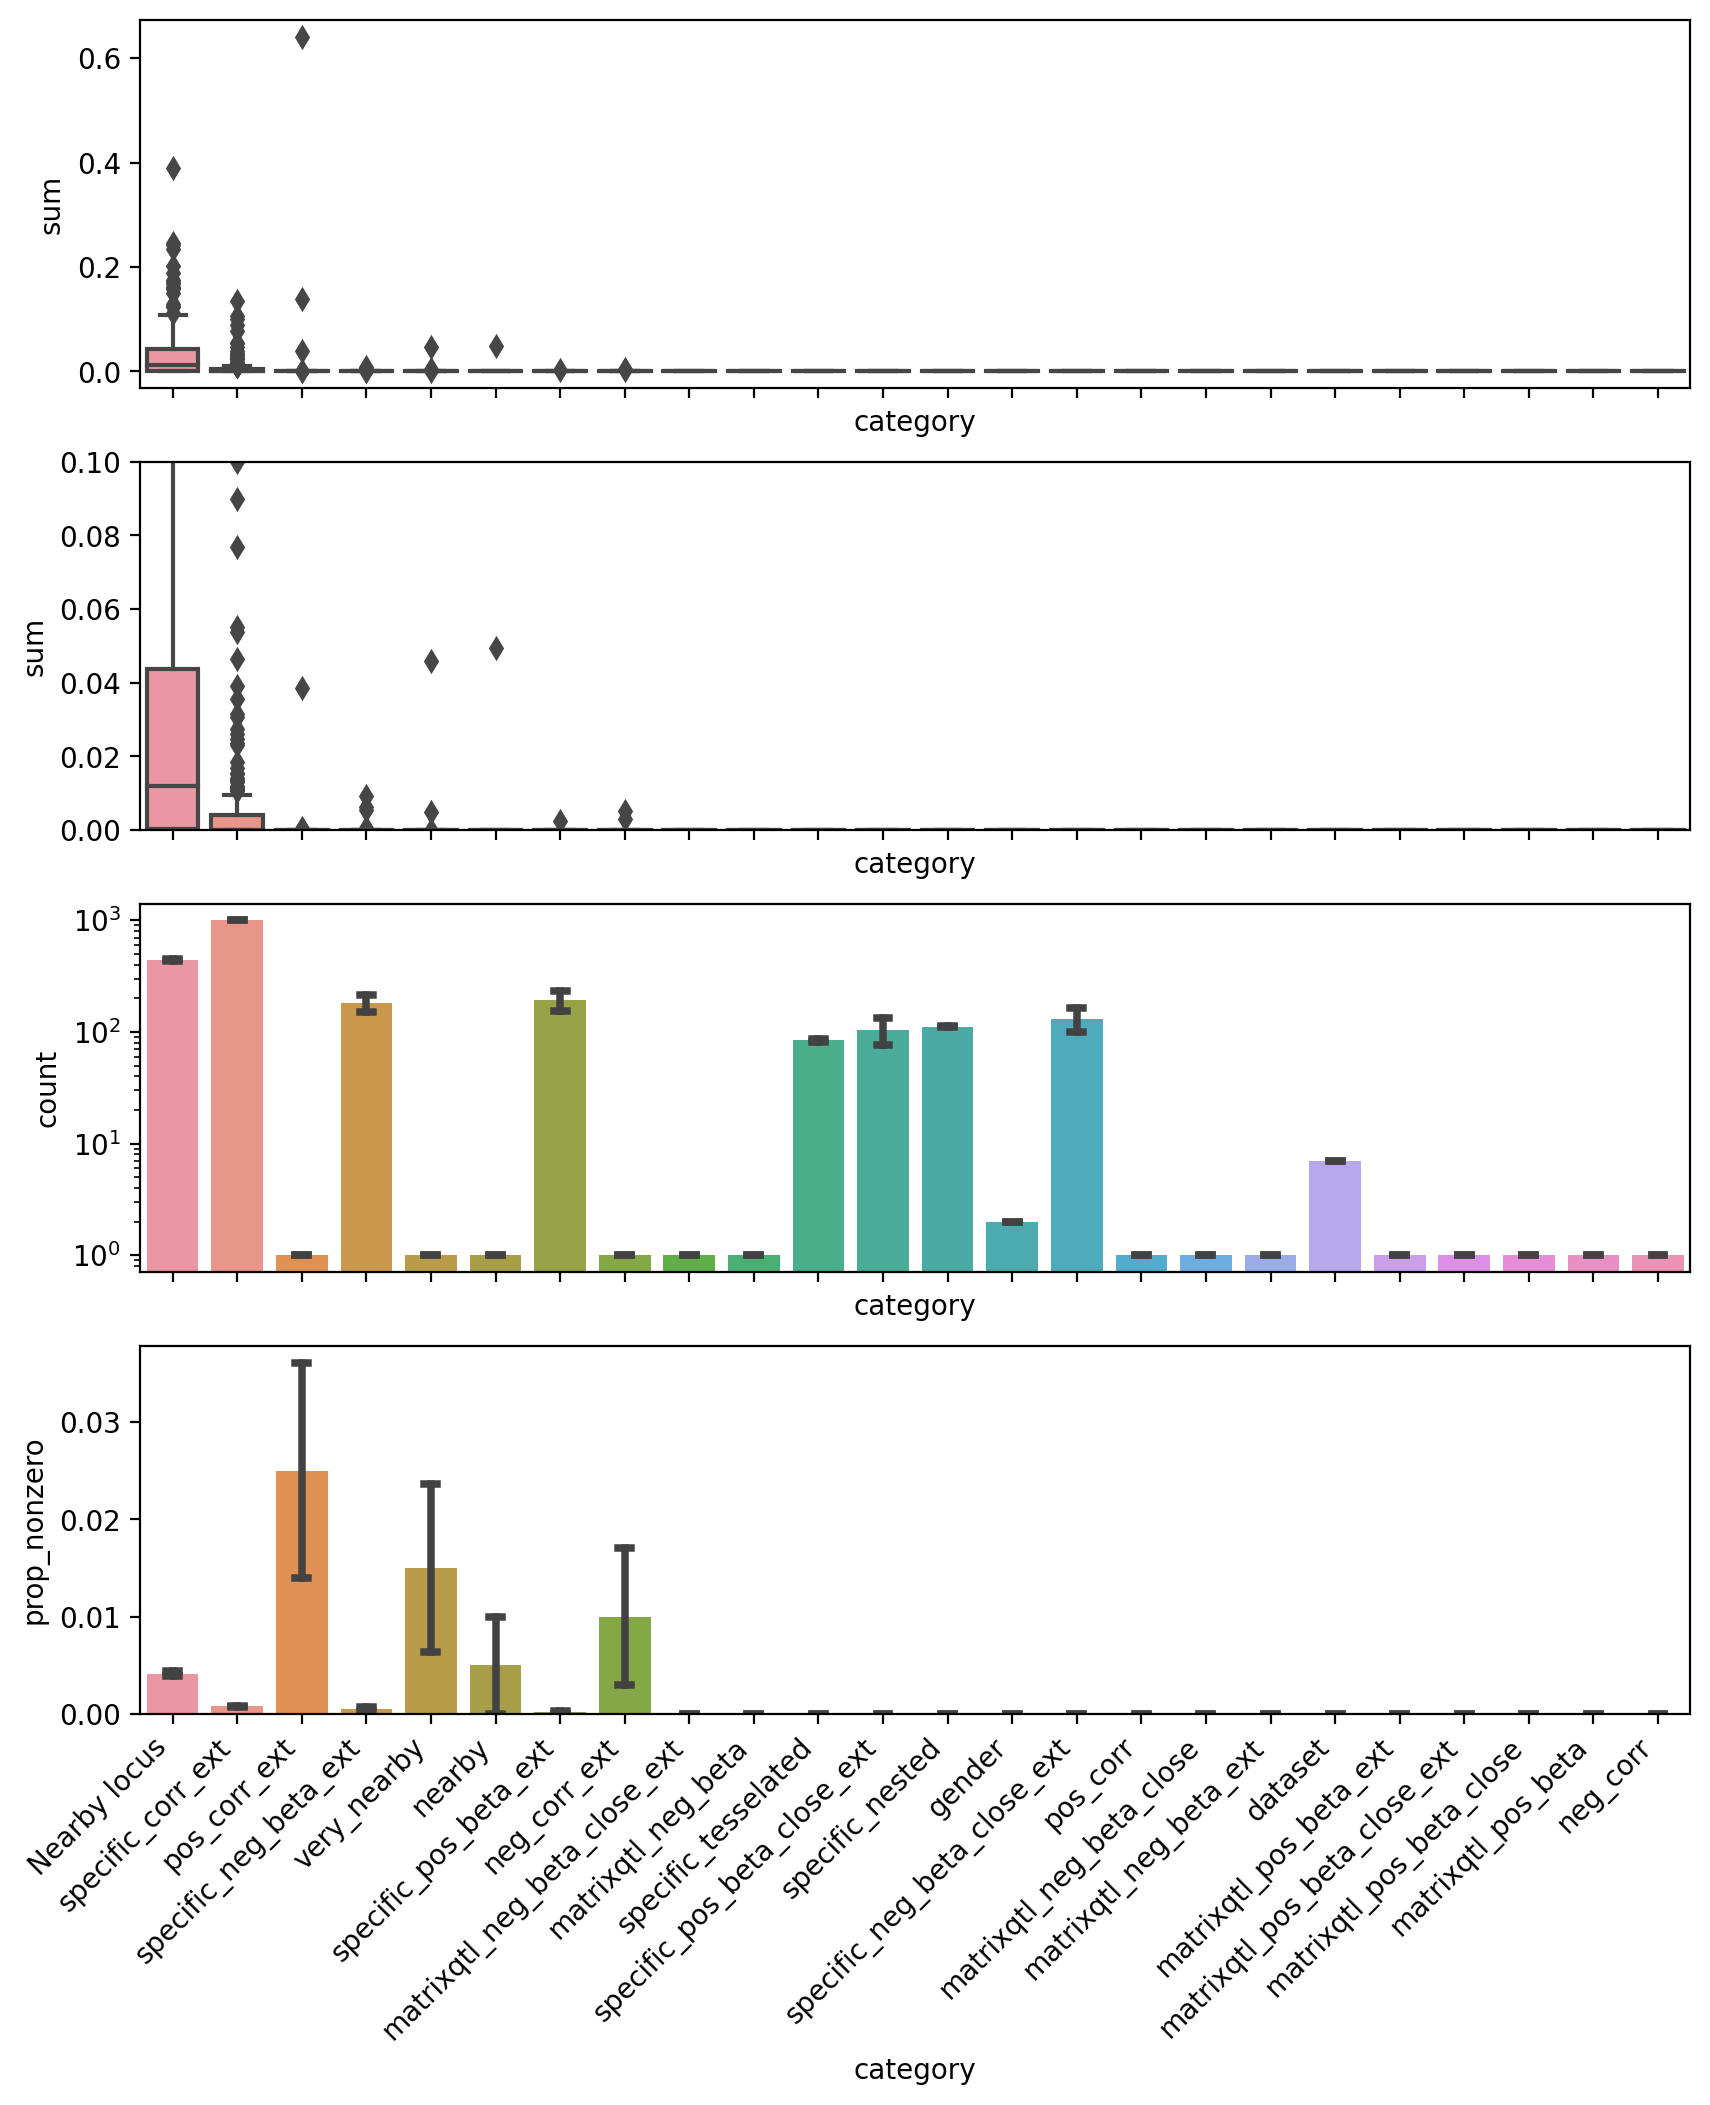

In [80]:
metric = 'sum'

fig, axes = plt.subplots(4,1, figsize = (10,11), sharex = True)
order = (
    all_feat_imp_by_cat_df
    .groupby("category")[metric]
    .mean()
    .sort_values(ascending = False).index
    )
sns.boxplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = metric,
    showfliers = True, ax = axes[0],
    order = order
    )

sns.boxplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = metric,
    showfliers = True, ax = axes[1],
    order = order
    )
axes[1].set_ylim(0, 0.1)
# log scale y axis
#axes[0].set_yscale('log')
# angle x labels
_ = plt.xticks(rotation=45, ha='right')

sns.barplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = "count",
    ax = axes[2],
    order = order, errorbar = 'se',
    capsize=0.2
    
    )
# set y axis to log scale
axes[2].set_yscale('log')

sns.barplot(
    data = all_feat_imp_by_cat_df,
    x = "category", y = "prop_nonzero",
    ax = axes[3],
    order = order, errorbar = 'se',
    capsize=0.2
    )

# Get sequences surrounding each CpG

In [52]:
# load reference genome
from pyfaidx import Fasta
reference_genome = Fasta(
    '/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/hg19.fa'
    )

In [57]:
illumina_cpg_locs_df

,#id,chr,start,Strand
0,cg00035864,Y,8553009,F
1,cg00050873,Y,9363356,R
2,cg00061679,Y,25314171,R
3,cg00063477,Y,22741795,F
4,cg00121626,Y,21664296,R
...,...,...,...,...
485457,cg27657537,22,20863762,F
485458,cg27660038,22,20378532,F
485459,cg27662284,22,20342520,F
485460,cg27662611,22,38598981,F


In [73]:
# get 1000bp upstream and downstream of each cpg in illumina_cpg_locs_df
illumina_cpg_locs_df['surrounding_sequences'] = illumina_cpg_locs_df.apply(
    lambda x: reference_genome['chr'+x['chr']][x['start']-15000:x['start']+15000].seq.upper(), axis = 1
)

In [81]:
# write sequences to fasta file with cpg names as sequence names
sequences = illumina_cpg_locs_df.apply(lambda row: f'>{row["#id"]}\n{row["surrounding_sequences"]}\n', axis=1).str.cat()
seq_fasta_fn = "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/15kb_seq_each_side_each_illum_cpg.fasta"
with open(seq_fasta_fn, 'w') as file:
    file.write(sequences)

# Methyl motifs

### split each to own file

In [110]:
def extract_motifs(meme_file, out_dir):
    with open(meme_file, 'r') as file:
        content = file.read()

    header_end = content.find('MOTIF')
    header = content[:header_end].strip()
    motifs = content[header_end:].split('MOTIF ')[1:]
    for motif in motifs:
        motif_lines = motif.strip().split('\n')
        motif_name = motif_lines[0].split()[0]
        motif_info = '\n'.join(motif_lines[1:])

        motif_file = f'{motif_name}.meme'
        with open(os.path.join(out_dir, motif_file), 'w') as file:
            file.write(f'{header}\n\nMOTIF {motif_name} {motif_name}\n\n{motif_info}\n')
        
        print(f'Saved motif {motif_name} to {motif_file}')
        

In [111]:
extract_motifs("/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/topEnriched.313.meme", "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/wang_methyl_motifs_313")

Saved motif UM_3582.2_3.88_0.56_57_known-TEAD2 to UM_3582.2_3.88_0.56_57_known-TEAD2.meme
Saved motif MM_983.8_2.26_0.62_9_ACTCCWGCC to MM_983.8_2.26_0.62_9_ACTCCWGCC.meme
Saved motif MM_814.4_2.02_0.62_8_known-PAX5 to MM_814.4_2.02_0.62_8_known-PAX5.meme
Saved motif MM_782.1_2.32_0.62_8_GCACTTTGGG to MM_782.1_2.32_0.62_8_GCACTTTGGG.meme
Saved motif UM_741.9_2.41_0.64_8_TTTCCGCGCG to UM_741.9_2.41_0.64_8_TTTCCGCGCG.meme
Saved motif UM_693.4_5.14_0.57_10_CGCGCGCGC to UM_693.4_5.14_0.57_10_CGCGCGCGC.meme
Saved motif MM_638.1_2.34_0.60_7_AGTGSTGGG to MM_638.1_2.34_0.60_7_AGTGSTGGG.meme
Saved motif UM_607.1_2.98_0.59_8_CCGCCCCGCK to UM_607.1_2.98_0.59_8_CCGCCCCGCK.meme
Saved motif UM_482.3_2.42_0.64_4_CGCGCGYTTB to UM_482.3_2.42_0.64_4_CGCGCGYTTB.meme
Saved motif MM_450.9_2.18_0.61_5_GAGGTKGCAG to MM_450.9_2.18_0.61_5_GAGGTKGCAG.meme
Saved motif MM_450.0_2.33_0.63_3_ACCCCGTCT to MM_450.0_2.33_0.63_3_ACCCCGTCT.meme
Saved motif MM_436.4_2.44_0.61_3_known-TFAP2A to MM_436.4_2.44_0.61_3_known-

### Testing

In [172]:
all_motif_occurence_df = methylation_motifs.search_motifs_in_surrounding_seqs(
    surrounding_seq_fasta_fn = "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/small_15kb_seq_each_side_each_illum_cpg.fasta",
    motif_dir = "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/wang_methyl_motifs_313",
    out_fn = "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences_near_cpg_15kb.parquet"
    )

In [174]:
all_motif_occurence_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences_near_cpg_15kb.parquet")

In [175]:
all_motif_occurence_df

,cpg_name,motif_name,motif_start,motif_stop,strand,score,pvalue,qvalue,start_distance_to_cpg
0,cg01707559,MM_271.6_2.03_0.58_8_ACCVKGCCC,912,904,-,15.898990,0.000003,0.135647,-14088
1,cg00271873,MM_271.6_2.03_0.58_8_ACCVKGCCC,1543,1551,+,15.898990,0.000003,0.135647,-13457
2,cg01900066,MM_271.6_2.03_0.58_8_ACCVKGCCC,2107,2099,-,15.898990,0.000003,0.135647,-12893
3,cg00272582,MM_271.6_2.03_0.58_8_ACCVKGCCC,2478,2486,+,15.898990,0.000003,0.135647,-12522
4,cg01463110,MM_271.6_2.03_0.58_8_ACCVKGCCC,3290,3298,+,15.898990,0.000003,0.135647,-11710
...,...,...,...,...,...,...,...,...,...
931,cg00050873,MM_782.1_2.32_0.62_8_GCACTTTGGG,23964,23973,+,9.134146,0.000096,0.336980,8964
932,cg00543493,MM_782.1_2.32_0.62_8_GCACTTTGGG,24139,24148,+,9.134146,0.000096,0.336980,9139
933,cg00903245,MM_782.1_2.32_0.62_8_GCACTTTGGG,25409,25418,+,9.134146,0.000096,0.336980,10409
934,cg00213748,MM_782.1_2.32_0.62_8_GCACTTTGGG,28720,28729,+,9.134146,0.000096,0.336980,13720


In [7]:
sequences = [
    Sequence(str(record.seq), name=record.id.encode())
    for record in Bio.SeqIO.parse("/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/small_15kb_seq_each_side_each_illum_cpg.fasta", "fasta")
]

In [8]:
motif_fn = "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/wang_methyl_motifs_313/UM_34.9_2.54_0.54_3_ARAGCCTGT.meme"
with MotifFile(motif_fn) as motif_file:
    motif = motif_file.read()

# create a FIMO object
fimo = FIMO(both_strands=True, max_stored_scores=1000000)
# search for the motif in the sequences
pattern = fimo.score_motif(motif, sequences, motif_file.background)
# print the results
motif_occurence_dict = {}
i = 0
for m in pattern.matched_elements:
    motif_occurence_dict[i] = {'cpg_name': m.source.accession.decode(), 'motif_name': motif.name.decode(), 'motif_start': m.start, 'motif_stop': m.stop, 'strand': m.strand, 'score': m.score, 'pvalue': m.pvalue, 'qvalue': m.qvalue}
    i += 1
motif_occurence_df = pd.DataFrame.from_dict(motif_occurence_dict, orient = 'index')
motif_occurence_df['start_distance_to_cpg'] = motif_occurence_df.apply(
    lambda x: x['motif_start'] - 15000, axis = 1
    )